In [23]:
import sys

sys.path.insert(1, '..')
from custom_functions import ProcessRawData

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier

# Preprocess

In [25]:
# df_train = pd.read_csv('../data/clean_train.csv')
train = pd.read_csv('../data/train.csv')
df_train = ProcessRawData.preprocessing(train)

In [26]:
CMAP = ['#003f5c', '#ffa600', '#444e86', '#955196', '#dd5182', '#ff6e54']

In [27]:
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize', 'FamilySize']

cat_cols = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide', 'CabinGroup', 'CryoSleep', 'VIP', 'ZeroSpend', 'Alone']

binary_cols = ['CryoSleep', 'VIP', 'ZeroSpend', 'Alone']

In [28]:
def numerize_feats(features):
    """Return categorical and binary features as numbers with mapping and dummy variables"""
    for col in ['CryoSleep', 'VIP', 'ZeroSpend', 'Alone']:
        features[col] = features[col].map({True:1, False:0})
        
    return pd.get_dummies(features, drop_first=True)



In [29]:
X = df_train.drop(['PassengerId', 'Transported'], axis=1)
y = df_train.Transported.replace({True:1, False:0})

In [30]:
X = numerize_feats(X)

# Base Models

Assess some default sklearn models to have some baseline on model performances.

Note: For Logistic Regression and Support Vector Machine, it's better to scale. It is not required per se for logistic regression but it helps the model converge so we don't have to increase max iterations. 

In [31]:
# default classifiers
LR_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
    ])

SVC_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='linear'))
    ])

# use random_state/seed where applicable for reproducability
clfs = {
    'LogisticRegression': LR_pipe,
    'SupportVector': SVC_pipe,
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_seed=42, verbose=0)
    }


In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.1, random_state=42)



In [33]:
# cross validation
mean_scores = []
for model in clfs.values():
    mean_score = cross_val_score(
        model, X_train, y_train, scoring='accuracy', cv=5).mean()
    mean_scores.append(mean_score)


# create new dataframe to display scores
scores_df = pd.DataFrame({
    'Model': clfs.keys(),
    'MeanCV_Score': mean_scores
    })
scores_df.sort_values('MeanCV_Score', ascending=False)

,Model,MeanCV_Score
6,CatBoost,0.816184
4,GradientBoosting,0.806341
3,RandomForest,0.801101
0,LogisticRegression,0.797138
1,SupportVector,0.793686
5,AdaBoost,0.793048
2,DecisionTree,0.750097


Looks like CatBoost and GradientBoosting are the top performer right out of the box. The results are also quite similar with a slight edge on the CatBoost. Let's see how they perform on the validation set.

In [34]:
# add validation score to the dataframe
for name, model in clfs.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_df.loc[scores_df.Model==name, 'ValidationScore'] = \
        accuracy_score(y_test, y_pred)
        
    scores_df.loc[scores_df.Model==name, 'ScoreDiff'] = \
        scores_df['MeanCV_Score'] - scores_df['ValidationScore']

scores_df.sort_values('ValidationScore', ascending=False)

,Model,MeanCV_Score,ValidationScore,ScoreDiff
6,CatBoost,0.816184,0.798851,0.017333
4,GradientBoosting,0.806341,0.783908,0.022433
1,SupportVector,0.793686,0.775862,0.017824
5,AdaBoost,0.793048,0.775862,0.017186
3,RandomForest,0.801101,0.772414,0.028687
0,LogisticRegression,0.797138,0.765517,0.031621
2,DecisionTree,0.750097,0.733333,0.016764


Okay, the top two remain the same. We get about 1-3% accuracy drop when using hold out data, which is not too bad. Before we tune the hyperparameters, we could do feature selection to see if we could get better performance for the top model (CatBoost) with less features. 

In [35]:
# create a function to quickly see the accuracy score
def model_score(estimator, X_train, X_test, y_train, y_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    message = f"Score for {estimator}: {score}"
    return message

# Feature Selection

## Methods
There are three methods we can use for feature selection: Filter Methods, Wrapper Methods, and Embedded Methods. Filter methods are done by using statistical tests such as ANOVA, Chi Square, etc. It is the quickest and cheapest option. 
Wrapper methods are more computationally rigorous but typically results in better performance. Embedded methods are methods embedded within the models such as LASSO Regularization. 

## Feature Importance

First, we'll look at the feature importance of several models to see what features overlap.

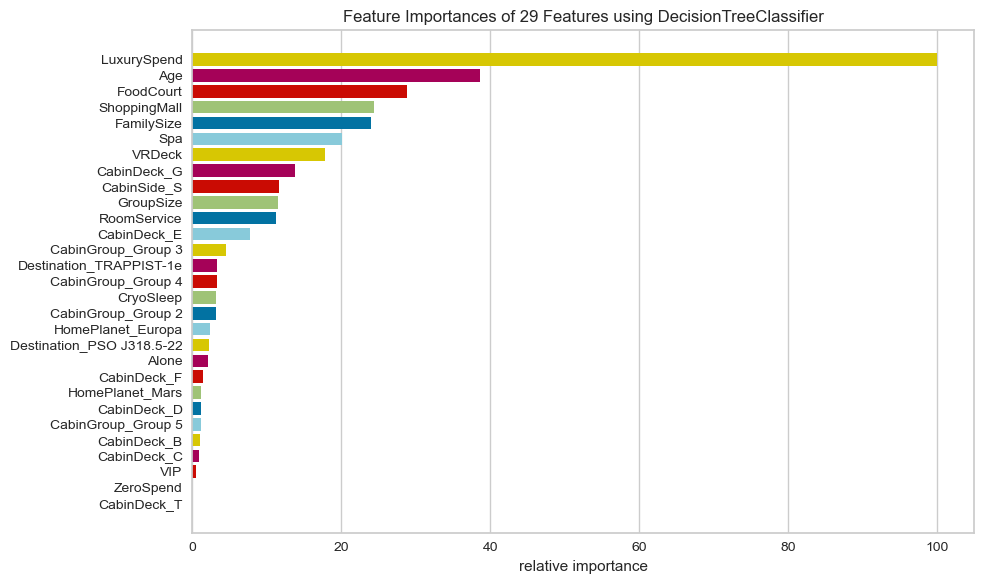

In [36]:
# look at CatBoost's feature importance to see what the model considers important
from yellowbrick.model_selection import FeatureImportances

plt.figure(figsize=(10,6), dpi=100)
dt = DecisionTreeClassifier(random_state=42)
viz = FeatureImportances(dt)
viz.fit(X_train, y_train)
viz.show();

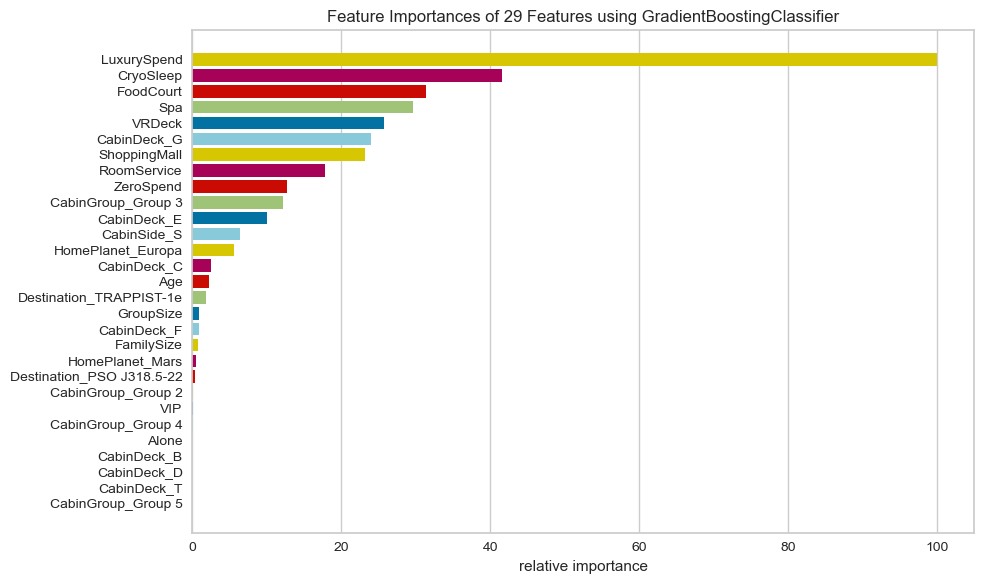

In [37]:
plt.figure(figsize=(10,6), dpi=100)
gb = GradientBoostingClassifier(random_state=42)
viz = FeatureImportances(gb)
viz.fit(X_train, y_train)
viz.show();

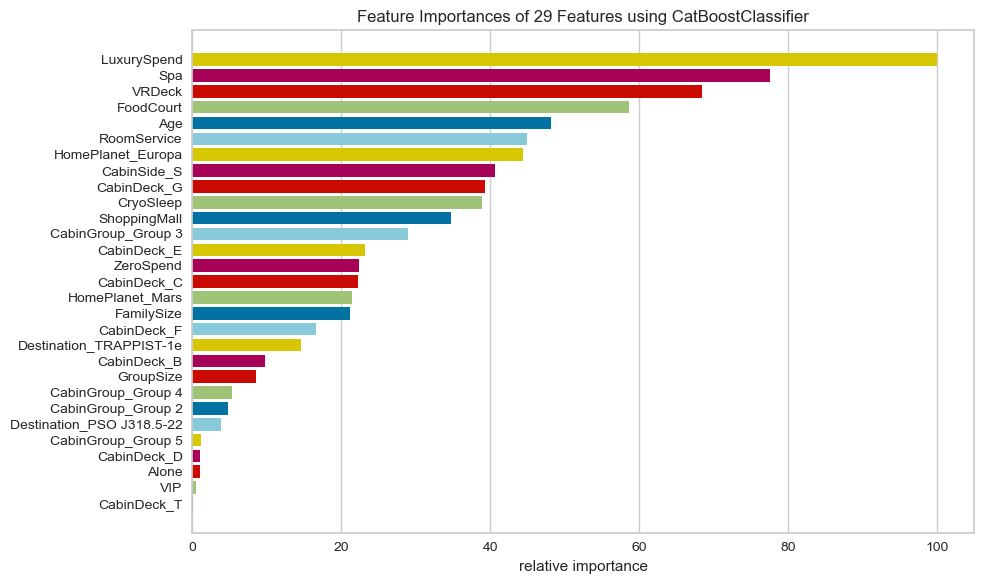

In [38]:
from yellowbrick.contrib.wrapper import wrap
from yellowbrick.model_selection import feature_importances

plt.figure(figsize=(10,6), dpi=100)

# need wrap to use third party estimator like CatBoost
catboost = wrap(CatBoostClassifier(verbose=0))
catboost.fit(X_train, y_train)
oz = feature_importances(catboost, X_test, y_test, is_fitted=True)


<li>The spending features consistenly shown to be the top 10 features across all three models.</li>
<li>Conversely, Cabin Deck D, T, Alone and VIP are shown to be the least important.</li>

Let's now see how features affect performance for the CatBoost model.

In [39]:
# this takes 3 hours
# from sklearn.model_selection import RepeatedStratifiedKFold
# from yellowbrick.model_selection import rfecv

# cv = RepeatedStratifiedKFold()
# viz = rfecv(
#     estimator=GradientBoostingClassifier(),
#     X=X_train,
#     y=y_train,
#     cv=cv,
#     scoring='accuracy')

Optimal number of features : 23


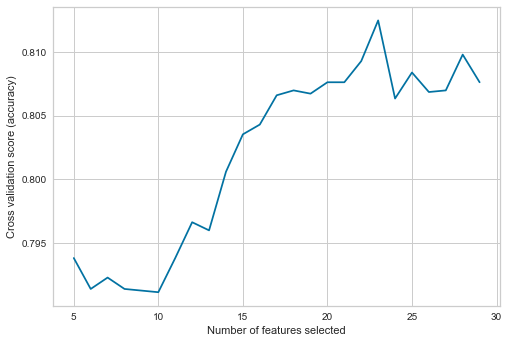

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
base_cat = CatBoostClassifier(verbose=0, random_state=42)
# base_cat = GradientBoostingClassifier()
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 5  # Minimum number of features to consider
rfecv = RFECV(
    estimator=base_cat,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
    rfecv.cv_results_['mean_test_score'],
)
plt.show()



In [41]:
# save the subset of features deemed to be the best
catboost_feat_set = rfecv.get_feature_names_out()

In [57]:
catboost_feat_set.shape

(23,)

In [43]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

cat_params = {
    'n_estimators': [50, 100, 150, 200, 500, 1000, 2000],
    'learning_rate': [0.005, 0.01, 0.02 ,0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6],
    'boost_from_average': [True, False]
}

model = CatBoostClassifier(verbose=0, random_state=42, eval_metric='Accuracy')
# model = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(model,
                param_grid=cat_params,
                scoring='accuracy',
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                n_jobs=-1)

grid_search.fit(X_train[catboost_feat_set], y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000022B8EF9C940>,
             n_jobs=-1,
             param_grid={'boost_from_average': [True, False],
                         'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1, 0.15,
                                           0.2],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 150, 200, 500, 1000, 2000]},
             scoring='accuracy')

In [44]:
grid_search.best_params_
# {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200} catboost
# {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200} gradientboost

# {'boost_from_average': False,
#  'learning_rate': 0.05,
#  'max_depth': 6,
#  'n_estimators': 500}

{'boost_from_average': False,
 'learning_rate': 0.15,
 'max_depth': 6,
 'n_estimators': 150}

In [45]:
grid_search.cv_results_['mean_test_score'].mean()
# 0.806027425173431

0.8013312479457682

# Model Performance

In [46]:
best_params = grid_search.best_params_
best_clf = CatBoostClassifier(**best_params, verbose=0, random_state=42, eval_metric='Accuracy')
# best_clf = GradientBoostingClassifier(**best_params, random_state=42)
# check the results on holdout set X_test
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred)
# 0.8022988505747126

0.8045977011494253

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       443
           1       0.80      0.81      0.80       427

    accuracy                           0.80       870
   macro avg       0.80      0.80      0.80       870
weighted avg       0.80      0.80      0.80       870



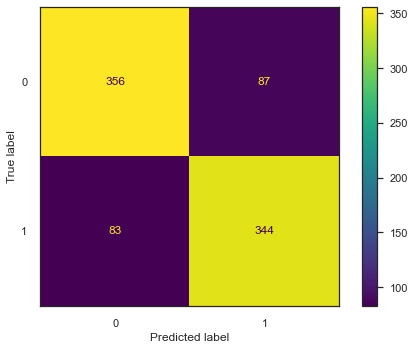

In [49]:
sns.set(style='white')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Model Feature Importance

In [50]:
y_prob = best_clf.predict_proba(X_test)

<AxesSubplot:ylabel='Count'>

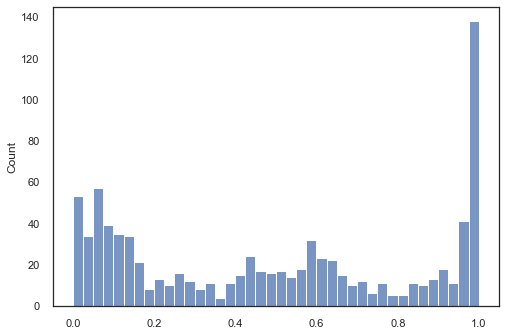

In [51]:
prob_of_1 = y_prob[:, 1]

sns.histplot(x=prob_of_1, bins=40)

In [52]:
# looking at best estimator
best_clf.fit(X_train[catboost_feat_set], y_train)

In [53]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train[catboost_feat_set]),
    feature_names=X_train[catboost_feat_set].columns,
    class_names=[0, 1],
    mode='classification'
)

In [54]:
exp = explainer.explain_instance(
    data_row=X_test[catboost_feat_set].iloc[0], 
    predict_fn=best_clf.predict_proba,
    num_features=5
)

exp.show_in_notebook(show_table=True)

The model is 96% confident this person is not transported. The values of VRDeck, FoodCourt, and RoomService affect the prediction the most. It's saying that the more spending on VRDeck someone has, the less likely they are to be transported and conversely, more money on FoodCourt means more probability of being transported. 

In [55]:
exp = explainer.explain_instance(
    data_row=X_test[catboost_feat_set].iloc[4], 
    predict_fn=best_clf.predict_proba,
    num_features=5
)

exp.show_in_notebook(show_table=True)

Now, we see a transported passenger. This model is 97% confident this passenger is transported. They have zero spending on VRDeck and RoomService which is the opposite of the passenger above has. 

We've seen a couple of local explanations by LIME. However, looking at a single prediction isn't enough to tell us how the model works in general. Here, we'll combine different aggregations of local explanations to get global aggregations to get a better generalization of how our current model works. 

In [58]:
def return_weights(exp):    
    """Get weights from LIME explanation object"""
    
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    
    return exp_weight

weights = []

#Iterate over first 100 rows in feature matrix
for i in range(0, 100):
    
    #Get explanation
    exp = explainer.explain_instance(data_row=X_test[catboost_feat_set].iloc[i], 
                                 predict_fn=best_clf.predict_proba, 
                                 num_features=23)
    
    #Get weights
    exp_weight = return_weights(exp)
    weights.append(exp_weight)
    
#Create DataFrame
lime_weights = pd.DataFrame(data=weights,columns=X_train[catboost_feat_set].columns)

Text(0.5, 0, 'Spa')

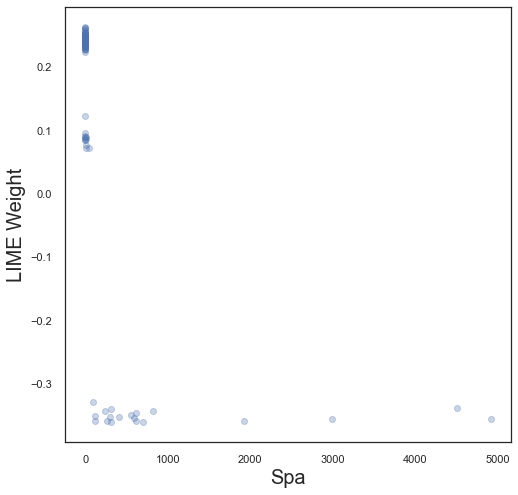

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

#Get weights and feature values
feature_weigth = lime_weights['Spa']
feature_value = X_test['Spa'][0:100]

plt.scatter(x=feature_value ,y=feature_weigth, alpha=0.3)

plt.ylabel('LIME Weight',size=20)
plt.xlabel('Spa',size=20)

Text(0.5, 0, 'Age')

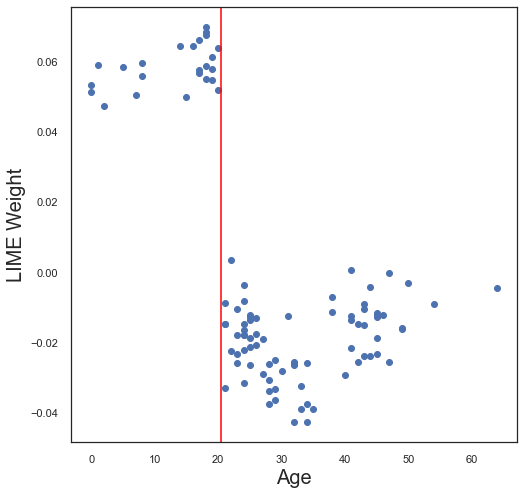

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

#Get weights and feature values
feature_weigth = lime_weights['Age']
feature_value = X_test['Age'][0:100]

plt.scatter(x=feature_value ,y=feature_weigth)

plt.ylabel('LIME Weight',size=20)
plt.axvline(x=20.5, color='red')
plt.xlabel('Age',size=20)

Looking at the aggregation of one of the features, Age, we can see that Age has a clear separation in terms of how the LIME weight increases/decreases. The chart is telling us that passenger under the age of 21 are more likely to be transported and vice versa. 

As for the other feature, Spa. If they don't spent any money there, they are more likely to be transported according to the chart, which could potentially make sense as the location of the spa might be enclosed and somehow safe from the transporting event. 

Text(0.5, 0, 'Mean |Weight|')

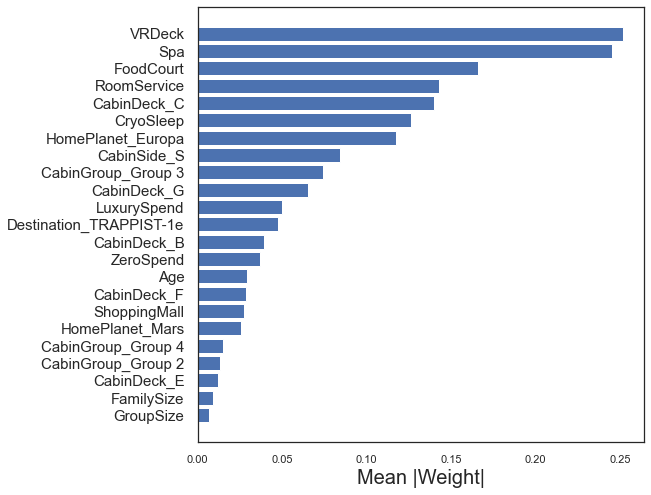

In [61]:
#Get abs mean of LIME weights
abs_mean = lime_weights.abs().mean(axis=0)
abs_mean = pd.DataFrame(data={'feature':abs_mean.index, 'abs_mean':abs_mean})
abs_mean = abs_mean.sort_values('abs_mean')

#Plot abs mean
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature
plt.barh(y=y_ticks,width=abs_mean.abs_mean)

plt.yticks(ticks=y_ticks,labels=y_labels,size= 15)
plt.title('')
plt.ylabel('')
plt.xlabel('Mean |Weight|',size=20)

These are the most important features when it comes to predicting whether somebody is going to be transported. The ranking of the features appear to be quite similar to what we obtained from the CatBoost' feature importance. 

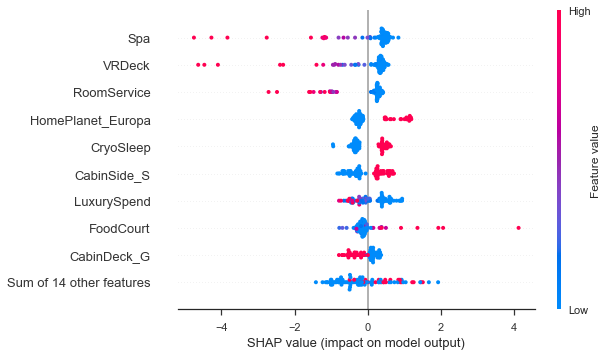

In [62]:
import shap

#Get SHAP values
explainer = shap.Explainer(best_clf)
shap_values = explainer(X_test[catboost_feat_set][0:100])

#Replace SHAP values with LIME weights
shap_placeholder = explainer(X_test[catboost_feat_set][0:100])
shap_placeholder.values = np.array(lime_weights)


#Beeswarm plot using SHAP values
shap.plots.beeswarm(shap_values,show=False)

Text(0.5, 0, 'LIME value')

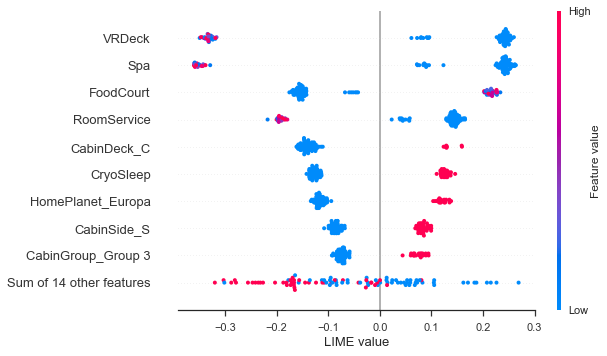

In [63]:
#Beeswarm plot using LIME values
shap.plots.beeswarm(shap_placeholder, show=False)
plt.xlabel('LIME value')

In [144]:
raw_train = pd.read_csv('../data/train.csv')
X_final = raw_train.drop('Transported', axis=1)
y_final = raw_train.Transported.replace({True:1, False:0})

In [145]:
from sklearn.feature_selection import RFE
final_model = CatBoostClassifier(**best_params, verbose=0, random_state=42, eval_metric='Accuracy')


# create function transformers for the preprocessing
trans_process_data = FunctionTransformer(ProcessRawData.preprocessing)
trans_dummy = FunctionTransformer(numerize_feats)

# column transformer
ct = ColumnTransformer([
    ('process_data', trans_process_data, X_final.columns),
    ('dummy',trans_dummy, X_final.columns)
])


feature_select = RFECV(
    estimator=final_model,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=10,
)

pipe = Pipeline(steps=[
    ('process_data', trans_process_data),
    ('dummy', trans_dummy),
    ('feature_select', feature_select),
    ('model', final_model)
])

In [146]:
pipe.fit(X_final, y_final)

Pipeline(steps=[('process_data',
                 FunctionTransformer(func=<function preprocessing at 0x0000022B9663D3A0>)),
                ('dummy',
                 FunctionTransformer(func=<function numerize_feats at 0x0000022B820A5CA0>)),
                ('feature_select',
                 RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
                       estimator=<catboost.core.CatBoostClassifier object at 0x0000022B97800C10>,
                       min_features_to_select=10, scoring='accuracy')),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000022B97800C10>)])

In [147]:
from joblib import dump

dump(pipe, '../models/final_final_catboost.joblib')

['../models/final_final_catboost.joblib']

In [148]:
test = pd.read_csv('../data/test.csv')

In [149]:
test_X = test



In [150]:
from joblib import load
cat_model = load('../models/final_final_catboost.joblib')

In [151]:
# predictions = cat_model.predict(test_X)
pred = (cat_model.predict_proba(test_X)[:,1] >= 0.53).astype(bool)

In [152]:
pred

array([ True, False,  True, ...,  True,  True,  True])

In [153]:
# test['Transported'] = predictions
test['Transported'] = pred

In [154]:
submission = test[['PassengerId', 'Transported']]


In [142]:
submission.Transported.value_counts()

True     2237
False    2040
Name: Transported, dtype: int64

In [ ]:
# submission['Transported'] = submission['Transported'].replace({1:True, 0:False})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [155]:
submission.to_csv('../submission-files/final_final_catboost.csv', index=False)

In [ ]:
# TODO: create a full preprocessing pipeline
# FunctionTransformer
# ColumnTransformer
# https://stackoverflow.com/questions/31259891/put-customized-functions-in-sklearn-pipeline#:~:text=You%20actually%20can%20put%20all%20of%20these%20functions%20into%20a%20single%20pipeline!&text=that%20your%20functions-,transform%20your%20target%20in%20addition%20to%20your%20training%20data%20(i.e.,pipeline%20does%20not%20support%20this.

